# importe de modelo

In [10]:
from tensorflow.keras.applications import MobileNetV2

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image as image_ops
import matplotlib.pyplot as plt
import numpy as np
import os



In [12]:
img_width,img_height=224,224

model=MobileNetV2(weights='imagenet',
                include_top=False,
                input_shape=(img_height,img_width,3)
                )

In [13]:
def add_layer_at_bottom(bottom_model, num_classes):
   top_model = bottom_model.output
   top_model = GlobalAveragePooling2D()(top_model)
   top_model = Dense(1024,activation='relu')(top_model)
   top_model = Dense(1024,activation='relu')(top_model)
   top_model = Dense(1024,activation='relu')(top_model)
   top_model = Dense(1024,activation='relu')(top_model)
   top_model = Dense(1024,activation='relu')(top_model)
   top_model = Dense(512,activation='relu')(top_model)
   top_model = Dense(num_classes,activation='softmax')(top_model)

    
   return top_model

# Aqui se cargan los datos

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
directorio_training='D:/chestData/train'
val_data_dir='D:/chestData/test'
os.listdir(directorio_training)


['Covid', 'Normal', 'Viral Pneumonia']

In [16]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                
                                 
                                 horizontal_flip=True,
                                 fill_mode='nearest')

val_datagen=ImageDataGenerator(rescale=1./255)

In [17]:
batch_size=32

In [18]:
entrenador=train_datagen.flow_from_directory(directorio_training,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

validador=val_datagen.flow_from_directory(val_data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode='categorical')
test_images,test_labels= next(validador)
x_test, y_test = entrenador.next()

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


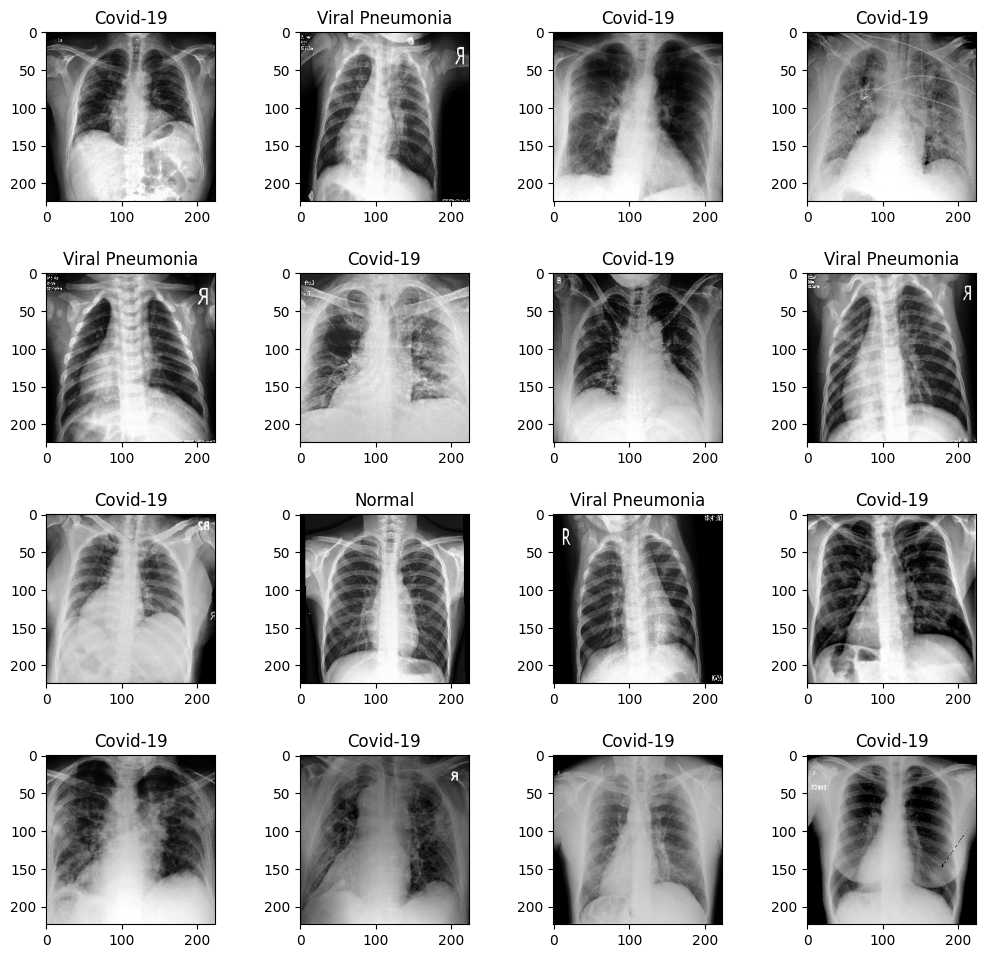

In [19]:
L = 4
W = 4
imagen_entrenamiento,labels_entrenamiento= next(entrenador)
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia'}

for i in np.arange(0, L*W):
    axes[i].imshow(imagen_entrenamiento[i])
    axes[i].set_title(label_names[np.argmax(labels_entrenamiento[i])])
    
    plt.subplots_adjust(wspace = 0.5)   

In [20]:
train_class_names = set()
num_train_samples=0
for i in entrenador.filenames:
    train_class_names.add(i.split('/')[0])
    num_train_samples+=1
#print(num_train_samples)
#train_class_names

In [21]:
val_class_names = set()
num_val_samples=0
for i in validador.filenames:
    val_class_names.add(i.split('/')[0])
    num_val_samples+=1
print(num_val_samples)
#val_class_names

66


In [22]:
num_classes=len(entrenador.class_indices)
print(num_classes)
FC_head=add_layer_at_bottom(model,
                            num_classes)

main_model=Model(inputs=model.input,
                 outputs=FC_head)

main_model.summary()

3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

# Training

In [23]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:

checkpoint = ModelCheckpoint("enfermedad_dec.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          restore_best_weights=True)

callbacks=[checkpoint,earlystop]

main_model.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(learning_rate=0.0015),
                   metrics=['accuracy'])

epochs=50

batch_size = 32

history = main_model.fit(entrenador,
                         steps_per_epoch=num_train_samples//batch_size,
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=validador,
                         validation_steps=num_val_samples//batch_size)



Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 2.5746 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 2.17288, saving model to enfermedad_dec.h5


c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 15s 2s/step - loss: 2.5746 - accuracy: 0.3333 - val_loss: 2.1729 - val_accuracy: 0.4062
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.5312
Epoch 2: val_loss did not improve from 2.17288
7/7 [==============================] - 10s 1s/step - loss: 0.8176 - accuracy: 0.5312 - val_loss: 29.2733 - val_accuracy: 0.3906
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.7677 - accuracy: 0.5890
Epoch 3: val_loss did not improve from 2.17288
7/7 [==============================] - 9s 1s/step - loss: 0.7677 - accuracy: 0.5890 - val_loss: 2.3442 - val_accuracy: 0.3906
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.8711 - accuracy: 0.5890
Epoch 4: val_loss did not improve from 2.17288
7/7 [==============================] - 9s 1s/step - loss: 0.8711 - accuracy: 0.5890 - val_loss: 6.4532 - val_accuracy: 0.4062
Epoch 5/50
7/7 [==============================] - ETA: 0s - loss: 0.6453 - a

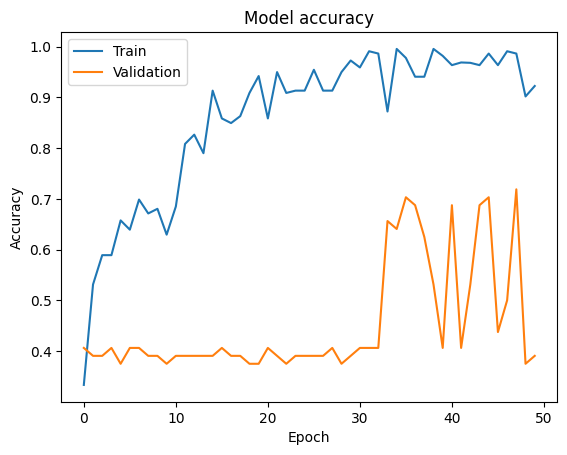

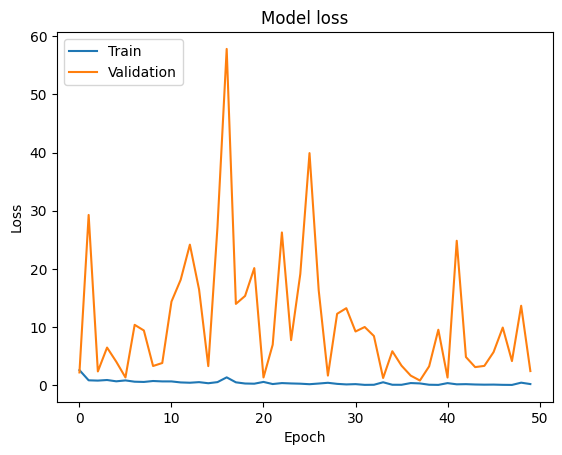

In [25]:
# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [26]:
from sklearn.metrics import confusion_matrix

# Predict
y_prediction = main_model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test, axis=1)

# Create confusion matrix and normalize it over predicted (columns)
result = confusion_matrix(y_test, y_prediction, normalize='pred')
print(result)


1/1 [==============================] - 1s 632ms/step
[[0.4375  0.      0.     ]
 [0.34375 0.      0.     ]
 [0.21875 0.      0.     ]]


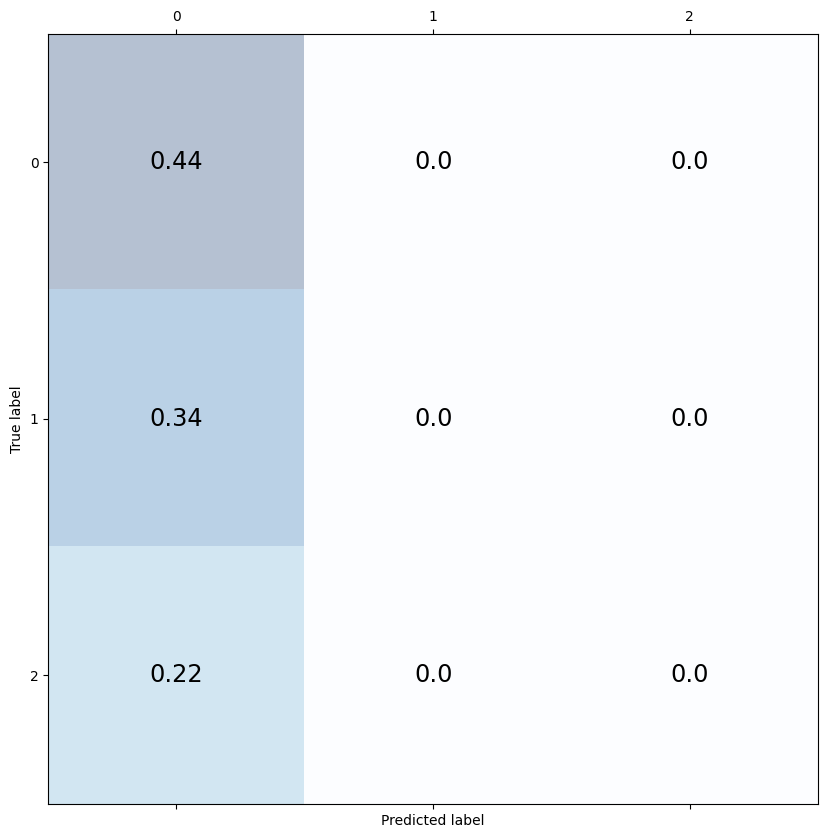

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(result, cmap=plt.cm.Blues, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i, s=round(result[i, j],2), va='center', ha='center', size='xx-large')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [28]:
import tkinter as tk
from tkinter import filedialog
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Aquí se debería importar y cargar el modelo entrenado 'main_model'
def abrir_archivo():
    file = filedialog.askopenfilename(initialdir="/", title="Seleccione archivo")
    if file:
        print("Archivo seleccionado: ", file)
        out=['Covid', 'Normal', 'Viral Pneumonia']
        img=cv2.imread(file)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(224,224))
        img=img/255.
        mostrar_imagen_con_titulo(img, out)

def mostrar_imagen_con_titulo(img, out):
    plt.imshow(img)
    img=img.reshape(1,224,224,3)
    res=main_model.predict(img)
    print(res)
    plt.title(out[np.argmax(res)])
    plt.show()

app = tk.Tk()
app.geometry("400x300")
app.title("Selector de archivos")

button = tk.Button(app, text="Abrir archivo", command=abrir_archivo)
button.pack(pady=20)

app.mainloop()

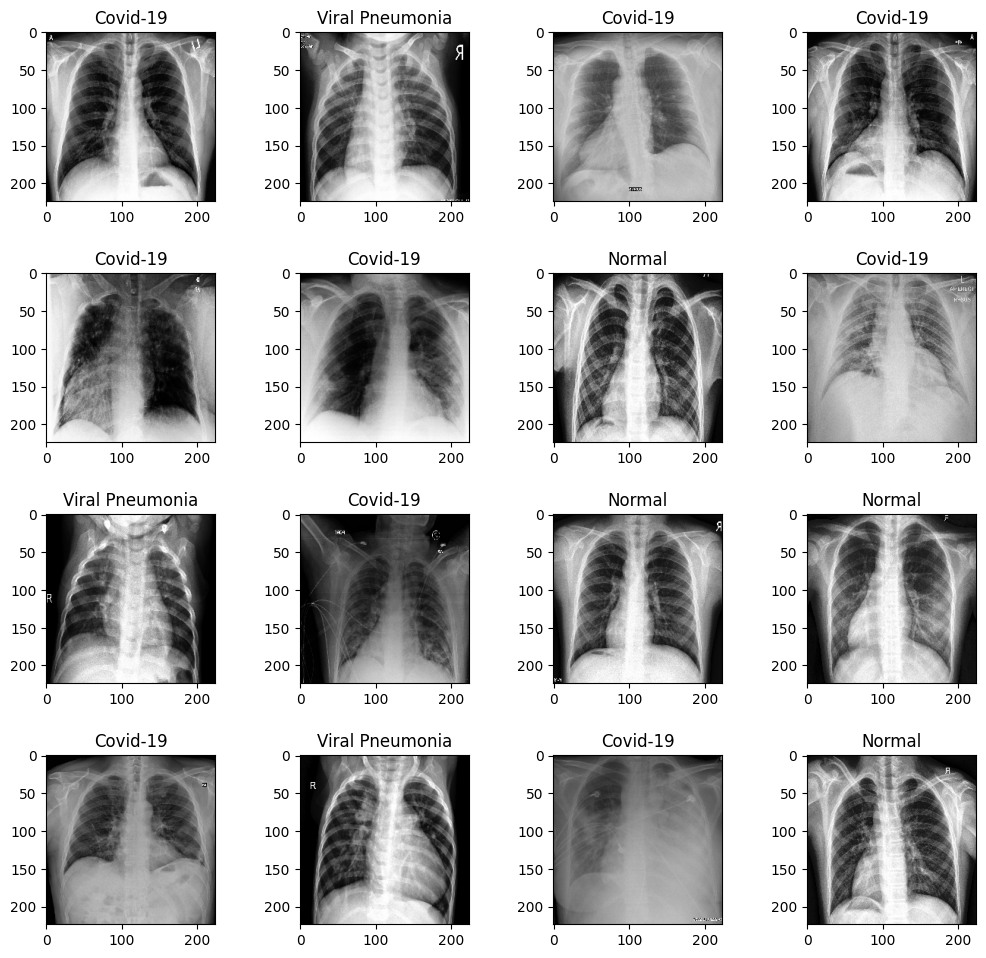

In [29]:
L = 4
W = 4
imagen_entrenamiento,labels_entrenamiento= next(entrenador)
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia'}

for i in np.arange(0, L*W):
    axes[i].imshow(imagen_entrenamiento[i])
    axes[i].set_title(label_names[np.argmax(labels_entrenamiento[i])])
    
    plt.subplots_adjust(wspace = 0.5)   

In [30]:
# import tkinter as tk
# from tkinter import filedialog
# import os
# import cv2
# import random
# import string
# import matplotlib.pyplot as plt
# import numpy as np

# out = ['Covid', 'Normal', 'Viral Pneumonia']

# def cambiar_nombres_carpeta_rnd(carpeta_ruta):
#     lista_archivos = os.listdir(carpeta_ruta)
#     print(carpeta_ruta)

#     for nombre_archivo in lista_archivos:
#         ruta_completa_antigua = os.path.join(carpeta_ruta, nombre_archivo)

#         if os.path.isfile(ruta_completa_antigua):
#             extension = os.path.splitext(nombre_archivo)[1]
#             nuevo_nombre = ''.join(random.choices(string.ascii_lowercase, k=10)) + extension
#             ruta_completa_nueva = os.path.join(carpeta_ruta, nuevo_nombre)

#             try:
#                 os.rename(ruta_completa_antigua, ruta_completa_nueva)
#                 print(f"Archivo {nombre_archivo} renombrado a {nuevo_nombre}")
#             except Exception as e:
#                 print(f"No se pudo cambiar el nombre del archivo {nombre_archivo}. Error: {e}")

# def seleccionar_carpeta_y_clasificar():
#     carpeta_ruta = filedialog.askdirectory()
#     etiqueta_ruta.config(text=f"Ruta de la carpeta seleccionada: {carpeta_ruta}")

#     for imagen_nombre in os.listdir(carpeta_ruta):
#         if imagen_nombre.endswith(('.jpg', '.jpeg', '.png')):
#             imagen_ruta = os.path.join(carpeta_ruta, imagen_nombre)
#             img = cv2.imread(imagen_ruta)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img = cv2.resize(img, (224, 224))
#             img = img / 255.
#             plt.imshow(img)
#             img = img.reshape(1, 224, 224, 3)
#             # Aquí deberías tener definido el modelo preentrenado como main_model
#             res = main_model.predict(img)
#             print(res)
#             print(out[np.argmax(res)])
            
            
            
#             plt.title(out[np.argmax(res)])
#             plt.show()

# # Configuración de la ventana
# ventana = tk.Tk()
# ventana.title("Selector de Carpeta e Impresión de Imágenes")

# # Botón para seleccionar la carpeta y clasificar imágenes
# boton_seleccionar = tk.Button(ventana, text="Seleccionar Carpeta e Imprimir Imágenes", command=seleccionar_carpeta_y_clasificar)
# boton_seleccionar.pack(pady=20)

# # Etiqueta para mostrar la ruta seleccionada
# etiqueta_ruta = tk.Label(ventana, text="Ruta de la carpeta seleccionada: ")
# etiqueta_ruta.pack(pady=10)

# # Ejecutar la ventana
# ventana.mainloop()


In [31]:
# import tkinter as tk
# from tkinter import filedialog
# import os
# import cv2
# import numpy as np
# from tensorflow.keras.models import load_model
# import matplotlib.pyplot as plt



# # Función para obtener y mostrar las imágenes
# def mostrar_imagenes_carpeta():
#     carpeta_ruta = filedialog.askdirectory()
#     etiqueta_ruta.config(text=f"Ruta de la carpeta seleccionada: {carpeta_ruta}")

#     # Obtener las imágenes y mostrarlas
#     fig = plt.figure(figsize=(10, 10))

#     for i, file in enumerate(os.listdir(carpeta_ruta)[:9]):
#         if file.endswith(".jpeg") or file.endswith(".jpg") or file.endswith(".png"):
#             img_path = os.path.join(carpeta_ruta, file)
#             img = cv2.imread(img_path)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img = cv2.resize(img, (224, 224))
#             img = img / 255.
#             img = img.reshape(1, 224, 224, 3)
#             res = main_model.predict(img)
#             prediction = out[np.argmax(res)]

#             ax = fig.add_subplot(3, 3, i + 1)
#             ax.imshow(img[0])
#             ax.set_title(f'Prediction: {prediction}')
#             ax.axis('off')

#     plt.show()

# # Configuración de la ventana
# ventana = tk.Tk()
# ventana.title("Selector de Carpeta y Visualizador de Imágenes")

# # Botón para seleccionar la carpeta y mostrar imágenes
# boton_seleccionar = tk.Button(ventana, text="Seleccionar Carpeta y Mostrar Imágenes", command=mostrar_imagenes_carpeta)
# boton_seleccionar.pack(pady=20)

# # Etiqueta para mostrar la ruta seleccionada
# etiqueta_ruta = tk.Label(ventana, text="Ruta de la carpeta seleccionada: ")
# etiqueta_ruta.pack(pady=10)

# # Ejecutar la ventana
# ventana.mainloop()


In [32]:
import tkinter as tk
from tkinter import filedialog
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageTk

# Carga el modelo (asegúrate de reemplazar 'ruta_al_modelo' con la ruta real del modelo)
#main_model = load_model('ruta_al_modelo')
out=['Covid', 'Normal', 'Viral Pneumonia']

# Configuración de la ventana de tkinter
ventana = tk.Tk()
ventana.title("Selector de Carpeta y Visualizador de Imágenes")
ventana.geometry("800x800")

# Función para obtener y mostrar las imágenes
def mostrar_imagenes_carpeta():
    carpeta_ruta = filedialog.askdirectory()
    etiqueta_ruta.config(text=f"Ruta de la carpeta seleccionada: {carpeta_ruta}")

    row_counter = 1
    column_counter = 0

    for file in os.listdir(carpeta_ruta)[:9]:
        if file.endswith(".jpeg") or file.endswith(".jpg") or file.endswith(".png"):
            img_path = os.path.join(carpeta_ruta, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            
            
            imgPre = img / 255.
            imgPre = imgPre.reshape(1, 224, 224, 3)
            res = main_model.predict(imgPre)
            prediction = out[np.argmax(res)]
            
            
            img = Image.fromarray(img)
            img = ImageTk.PhotoImage(img)
            panel = tk.Label(ventana, image=img)
            panel.image = img
            panel.grid(row=row_counter, column=column_counter, padx=10, pady=10)

            

            etiqueta_prediccion = tk.Label(ventana, text=f"Prediction: {prediction}")
            etiqueta_prediccion.grid(row=row_counter + 1, column=column_counter, padx=10)

            column_counter += 1
            if column_counter > 2:
                column_counter = 0
                row_counter += 2

# Etiqueta para mostrar la ruta seleccionada
etiqueta_ruta = tk.Label(ventana, text="Ruta de la carpeta seleccionada: ")
etiqueta_ruta.grid(row=0, column=0, padx=10, pady=10)

# Botón para seleccionar la carpeta y mostrar imágenes
boton_seleccionar = tk.Button(ventana, text="Seleccionar Carpeta y Mostrar Imágenes", command=mostrar_imagenes_carpeta)
boton_seleccionar.grid(row=1, column=0, padx=10, pady=10)

# Ejecutar la ventana
ventana.mainloop()
